In [30]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.io.shapereader import Reader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER,LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import math
from scipy import stats
%matplotlib inline

In [12]:
def gridline(ax, data, str1, str2, fontsize, lw):
# --设置网格点属性
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
        linewidth=lw, color='k', alpha=0.5, linestyle='--')
    gl.top_labels = False  # 关闭顶端的经纬度标签
    gl.right_labels = False  # 关闭右侧的经纬度标签
    gl.xformatter = LONGITUDE_FORMATTER  # x轴设为经度的格式
    gl.yformatter = LATITUDE_FORMATTER  # y轴设为纬度的格式

    maxlong = math.ceil(max(np.unique(data.coords[str1].values)))
    minlong = int(min(np.unique(data.coords[str1].values)))
    maxlat = math.ceil(max(np.unique(data.coords[str2].values)))
    minlat = int(min(np.unique(data.coords[str2].values)))
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    gl.ylocator = mticker.FixedLocator(np.arange(-90, 91, 30))
    gl.xlabel_style = {'size': fontsize, 'family':'Arial'}
    gl.ylabel_style = {'size': fontsize, 'family': 'Arial'}

In [14]:
world = cfeat.ShapelyFeature(Reader(r'D:\ESE5023data\2022世界国家\2022世界国家.shp').geometries(),
                                 ccrs.PlateCarree(), edgecolor='k', facecolor='none',lw=2)

# 1

In [4]:
ds1 = xr.open_dataset(r'D:\ESE5023data\NOAA_NCDC_ERSST_v3b_SST.nc')
ds1

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 684)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...

## 1.1

In [22]:
#select the region
ds1_Nino = ds1.sel(lat=slice(-5,5),lon=slice(190,240))
ds1_mean = ds1_Nino['sst'].mean(('lon','lat'))
#compute monthly SST climatology
ds1_clim_mm = ds1_mean.groupby(ds1.time.dt.month).mean()

In [25]:
#compute anomalies
ds1_ano = xr.zeros_like(ds1_mean)
for i in range(0,len(ds1_mean)):
    k = i % 12
    ds1_ano[i] = ds1_mean.values[i] - ds1_clim_mm.values[k]

## 1.2

In [38]:
#3-month running mean
index = np.zeros_like(ds1_ano[2:684])
for ii in range(0,len(index)):
    index[ii] = ds1_ano[ii:ii+3].values.mean()

(0.0, 682.0)

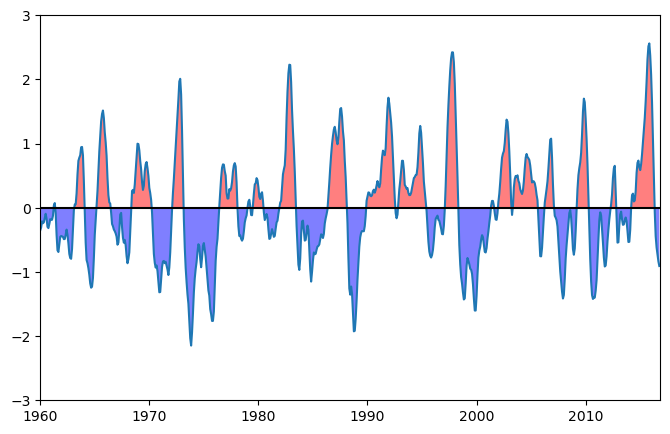

In [43]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(len(index)),index)
plt.plot(np.arange(len(index)),np.zeros_like(index),c='k')
plt.xticks(np.arange(0,len(index),120),np.arange(1960,2015,10))
plt.fill_between(np.arange(0,len(index)),0,index,where=index > 0,
                 fc='r',alpha=0.5)
plt.fill_between(np.arange(0,len(index)),index,0,where=index < 0,
                 fc='b',alpha=0.5)
plt.ylim(-3,3)
plt.xlim(0,len(index))

# 2

In [2]:
ds2 = xr.open_dataset(r'D:\ESE5023data\CERES_EBAF-TOA_200003-201701.nc')
ds2

<xarray.Dataset>
Dimensions:                      (lon: 360, time: 203, lat: 180)
Coordinates:
  * lon                          (lon) float32 0.5 1.5 2.5 ... 357.5 358.5 359.5
  * time                         (time) datetime64[ns] 2000-03-15 ... 2017-01-15
  * lat                          (lat) float32 -89.5 -88.5 -87.5 ... 88.5 89.5
Data variables: (12/14)
    toa_sw_all_mon               (time, lat, lon) float32 ...
    toa_lw_all_mon               (time, lat, lon) float32 ...
    toa_net_all_mon              (time, lat, lon) float32 ...
    toa_sw_clr_mon               (time, lat, lon) float32 ...
    toa_lw_clr_mon               (time, lat, lon) float32 ...
    toa_net_clr_mon              (time, lat, lon) float32 ...
    ...                           ...
    toa_cre_net_mon              (time, lat, lon) float32 ...
    solar_mon                    (time, lat, lon) float32 ...
    cldarea_total_daynight_mon   (time, lat, lon) float32 ...
    cldpress_total_daynight_mon  (time, lat, lon) float32 ...
    cldtemp_total_daynight_mon   (time, lat, lon) float32 ...
    cldtau_total_day_mon         (time, lat, lon) float32 ...
Attributes:
    title:             CERES EBAF (Energy Balanced and Filled) TOA Fluxes. Mo...
    institution:       NASA/LaRC (Langley Research Center) Hampton, Va
    Conventions:       CF-1.4
    comment:           Data is from East to West and South to North.
    Version:           Edition 4.0; Release Date March 7, 2017
    Fill_Value:        Fill Value is -999.0
    DOI:               10.5067/TERRA+AQUA/CERES/EBAF-TOA_L3B.004.0
    Production_Files:  List of files used in creating the present Master netC...

## 2.1

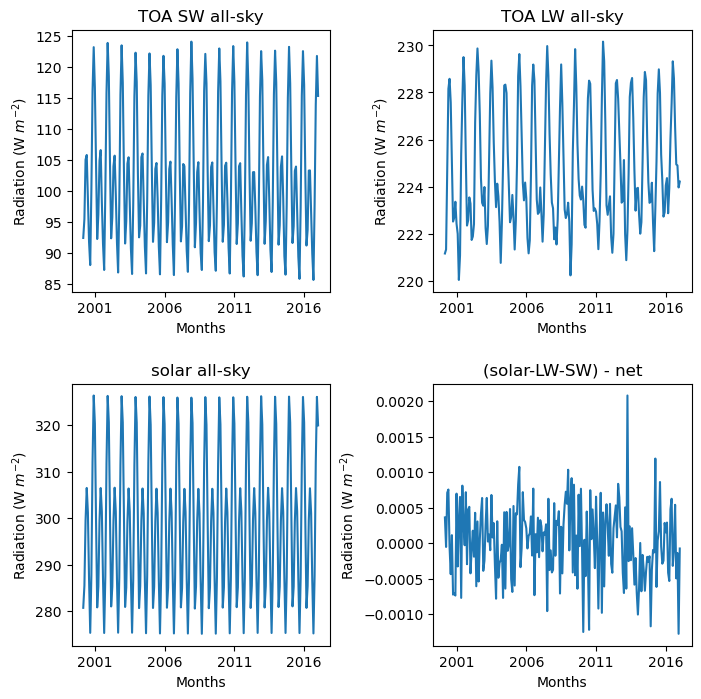

In [82]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(221)
ax1.plot(ds2['toa_sw_all_mon'].mean(('lon','lat')))
ax1.set(title='TOA SW all-sky',xlabel='Months',ylabel='Radiation (W $m^{-2}$)')
ax1.set_xticks(np.arange(10,203,60))
ax1.set_xticklabels(np.arange(2001,2017,5))

ax2 = fig.add_subplot(222)
ax2.plot(ds2['toa_lw_all_mon'].mean(('lon','lat')))
ax2.set(title='TOA LW all-sky',xlabel='Months',ylabel='Radiation (W $m^{-2}$)')
ax2.set_xticks(np.arange(10,203,60))
ax2.set_xticklabels(np.arange(2001,2017,5))

ax3 = fig.add_subplot(223)
ax3.plot(ds2['solar_mon'].mean(('lon','lat')))
ax3.set(title='solar all-sky',xlabel='Months',ylabel='Radiation (W $m^{-2}$)')
ax3.set_xticks(np.arange(10,203,60))
ax3.set_xticklabels(np.arange(2001,2017,5))

rad_sum = ds2['solar_mon'] - ds2['toa_sw_all_mon'] - ds2['toa_lw_all_mon']  - ds2['toa_net_all_mon']
ax4 = fig.add_subplot(224)
ax4.plot(rad_sum.mean(('lon','lat')))
ax4.set(title='(solar-LW-SW) - net',xlabel='Months',ylabel='Radiation (W $m^{-2}$)')
ax4.set_xticks(np.arange(10,203,60))
ax4.set_xticklabels(np.arange(2001,2017,5))
plt.subplots_adjust(hspace=0.35,wspace=0.4)

Since the difference between (solar-LW-SW) and net radiation is quite small, the three variables are equivalent to TOA net flux

## 2.2

In [85]:
weights = np.cos(np.deg2rad(ds2.lat))
weights.name = "weights"
#select the 10-year data just as the cartoon
print(ds2['solar_mon'].sel(time=slice('2001','2010')).weighted(weights).mean(('lon','lat')).mean())
print(ds2['toa_sw_all_mon'].sel(time=slice('2001','2010')).weighted(weights).mean(('lon','lat')).mean())
print(ds2['toa_lw_all_mon'].sel(time=slice('2001','2010')).weighted(weights).mean(('lon','lat')).mean())

<xarray.DataArray 'solar_mon' ()>
array(340.29135, dtype=float32)
<xarray.DataArray 'toa_sw_all_mon' ()>
array(99.27172, dtype=float32)
<xarray.DataArray 'toa_lw_all_mon' ()>
array(240.24297, dtype=float32)


The values of solar_mon matches the incoming solar radiation in the cartoon.  
The values of toa_sw_all_mon matches the total reflected solar radiation in the cartoon.  
The values of toa_lw_all_mon matchs the total outgoing infrared radiation in the cartoon.

## 2.3

([<matplotlib.axis.XTick at 0x1a307ab5090>,
 [Text(-75, 0, '-75$^{\\circ}$'),
  Text(-50, 0, '-50$^{\\circ}$'),
  Text(-25, 0, '-25$^{\\circ}$'),
  Text(0, 0, '0$^{\\circ}$'),
  Text(25, 0, '25$^{\\circ}$'),
  Text(50, 0, '50$^{\\circ}$'),
  Text(75, 0, '75$^{\\circ}$')])

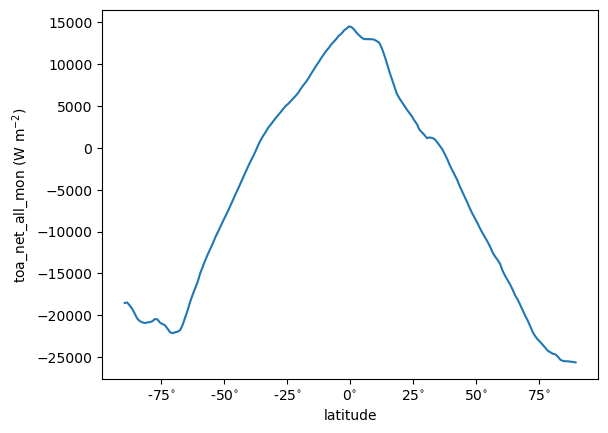

In [3]:
#total amount for whole period
time_tot = ds2['toa_net_all_mon'].sum(dim='time')
lat_mean = time_tot.mean(axis=1)
lat_mean.plot()
plt.ylabel('toa_net_all_mon (W m$^{-2}$)')
plt.xlabel('latitude')
plt.xticks([-75,-50,-25,0,25,50,75],['-75$^{\circ}$','-50$^{\circ}$','-25$^{\circ}$','0$^{\circ}$','25$^{\circ}$','50$^{\circ}$','75$^{\circ}$'])

## 2.4

In [7]:
mean_og_sw = ds2['toa_sw_all_mon'].mean('time')
mean_og_lw = ds2['toa_lw_all_mon'].mean('time')
mean_cldarea = ds2['cldarea_total_daynight_mon'].mean('time')

In [8]:
low_cldarea_sw = xr.where(mean_cldarea <= 25, mean_og_sw, np.nan)
high_cldarea_sw = xr.where(mean_cldarea >= 75, mean_og_sw, np.nan)
low_cldarea_lw = xr.where(mean_cldarea <= 25, mean_og_lw, np.nan)
high_cldarea_lw = xr.where(mean_cldarea >= 75, mean_og_lw, np.nan)

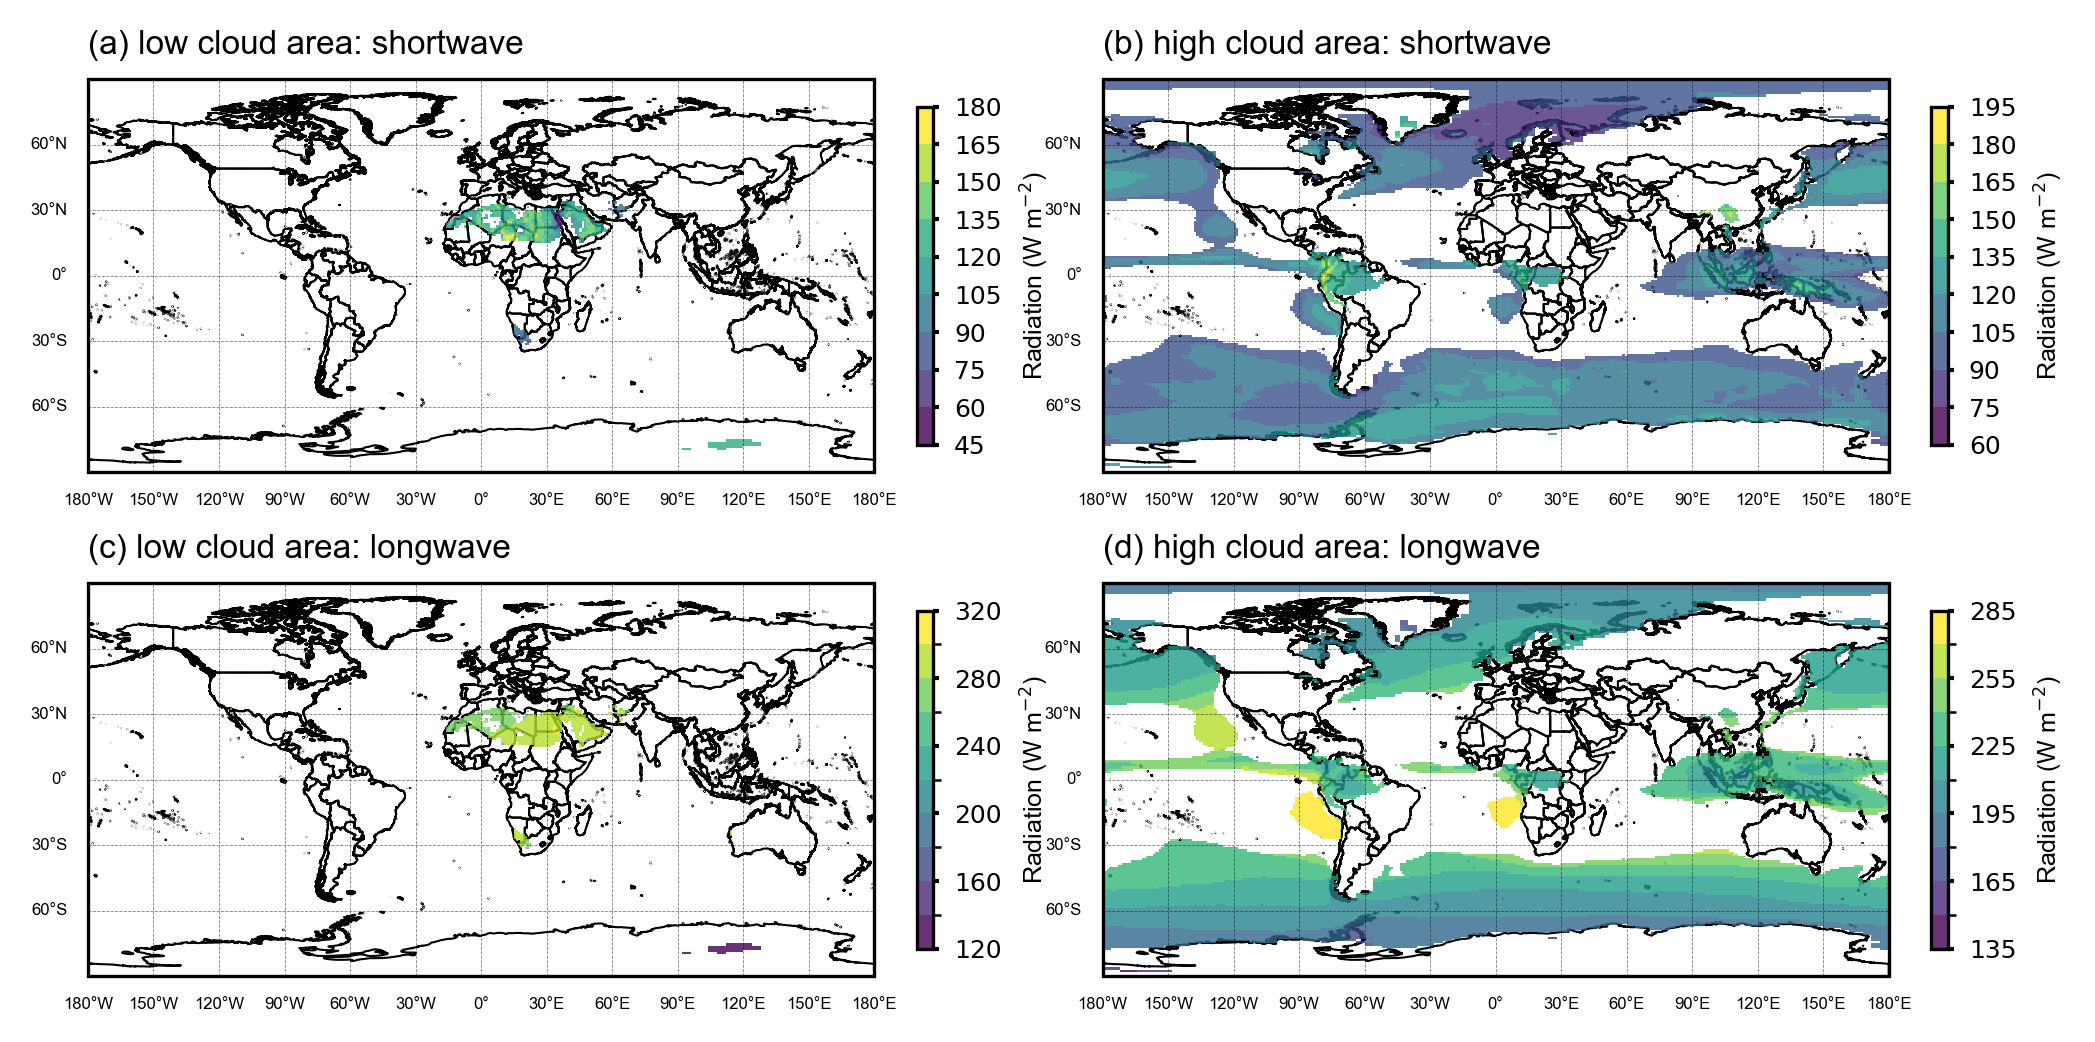

In [21]:
fig = plt.figure(figsize=(8,4),dpi=300)
ax1 = fig.add_subplot(221,projection = ccrs.PlateCarree())
ax1.add_feature(world, linewidth=0.5, zorder=1)
p1 = low_cldarea_sw.plot(x='lon', y='lat', transform = ccrs.PlateCarree(),alpha=0.8, add_colorbar=False,levels=10)
gridline(ax1, low_cldarea_sw, 'lon', 'lat', 4, 0.2)
ax1.set_title('(a) low cloud area: shortwave', fontdict={'size': 8,'family':'Arial'},loc='left')
cb1 = plt.colorbar(p1,fraction=0.02)
cb1.ax.tick_params(labelsize=6, length=1.5,width=1)
cb1.set_label('Radiation (W m$^{-2}$)', fontdict={'family':'Arial', 'size': 6})

ax2 = fig.add_subplot(222,projection = ccrs.PlateCarree())
ax2.add_feature(world, linewidth=0.5, zorder=1)
p2 = high_cldarea_sw.plot(x='lon', y='lat', transform = ccrs.PlateCarree(),alpha=0.8, add_colorbar=False,levels=10)
gridline(ax2, high_cldarea_sw, 'lon', 'lat', 4, 0.2)
ax2.set_title('(b) high cloud area: shortwave', fontdict={'size': 8,'family':'Arial'},loc='left')
cb2 = plt.colorbar(p2,fraction=0.02)
cb2.ax.tick_params(labelsize=6, length=1.5,width=1)
cb2.set_label('Radiation (W m$^{-2}$)', fontdict={'family':'Arial', 'size': 6})

ax3 = fig.add_subplot(223,projection = ccrs.PlateCarree())
ax3.add_feature(world, linewidth=0.5, zorder=1)
p3 = low_cldarea_lw.plot(x='lon', y='lat', transform = ccrs.PlateCarree(),alpha=0.8, add_colorbar=False,levels=10)
gridline(ax3, low_cldarea_lw, 'lon', 'lat', 4, 0.2)
ax3.set_title('(c) low cloud area: longwave', fontdict={'size': 8,'family':'Arial'},loc='left')
cb3 = plt.colorbar(p3,fraction=0.02)
cb3.ax.tick_params(labelsize=6, length=1.5,width=1)
cb3.set_label('Radiation (W m$^{-2}$)', fontdict={'family':'Arial', 'size': 6})

ax4 = fig.add_subplot(224,projection = ccrs.PlateCarree())
ax4.add_feature(world, linewidth=0.5, zorder=1)
p4 = high_cldarea_lw.plot(x='lon', y='lat', transform = ccrs.PlateCarree(),alpha=0.8, add_colorbar=False,levels=10)
gridline(ax4, high_cldarea_lw, 'lon', 'lat', 4, 0.2)
ax4.set_title('(d) high cloud area: longwave', fontdict={'size': 8,'family':'Arial'},loc='left')
cb4 = plt.colorbar(p4,fraction=0.02)
cb4.ax.tick_params(labelsize=6, length=1.5,width=1)
cb4.set_label('Radiation (W m$^{-2}$)', fontdict={'family':'Arial', 'size': 6})

plt.subplots_adjust(hspace=0.2,wspace=0.2)

## 2.5

In [22]:
weights = np.cos(np.deg2rad(ds2.lat))
weights.name = "weights"
low_cldarea_sw_mean = low_cldarea_sw.weighted(weights).mean(('lon','lat'))
high_cldarea_sw_mean = high_cldarea_sw.weighted(weights).mean(('lon','lat'))
low_cldarea_lw_mean = low_cldarea_lw.weighted(weights).mean(('lon','lat'))
high_cldarea_lw_mean = high_cldarea_lw.weighted(weights).mean(('lon','lat'))
print(low_cldarea_sw_mean.data,high_cldarea_sw_mean.data)
print(low_cldarea_lw_mean.data,high_cldarea_lw_mean.data)

122.5522 109.20795
280.6622 223.76877


The clouds overall decrease outgoing shortwave and longwave radiation. The clouds absorb radiation.

# 3

Dataset: CRU TS v4.07 temperature 2011-2020

In [23]:
ds3 = xr.open_dataset('D:\ESE5023data\cru_ts4.07.2011.2020.tmp.dat.nc')
ds3

<xarray.Dataset>
Dimensions:  (lon: 720, lat: 360, time: 120)
Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 2011-01-16 2011-02-15 ... 2020-12-16
Data variables:
    tmp      (time, lat, lon) float32 ...
    stn      (time, lat, lon) float64 ...
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.07 Mean Temperature
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2304141047. Data generated from:tmp.2304141039.dtb
    history:      Fri 14 Apr 11:30:51 BST 2023 : User f098 : Program makegrid...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    contact:      support@ceda.ac.uk

## 3.1

In [24]:
weights = np.cos(np.deg2rad(ds3.lat))
weights.name = "weights"
ds3_mean = ds3['tmp'].weighted(weights).mean(('lon','lat'))
#remove monthly seasonal cycle
ds3_clim_mm = ds3_mean.groupby(ds3.time.dt.month).mean()
ds3_ano = xr.zeros_like(ds3_mean)
for i in range(0,len(ds3_mean)):
    k = i % 12
    ds3_ano[i] = ds3_mean.values[i] - ds3_clim_mm.values[k]

Text(0.5, 0, 'year')

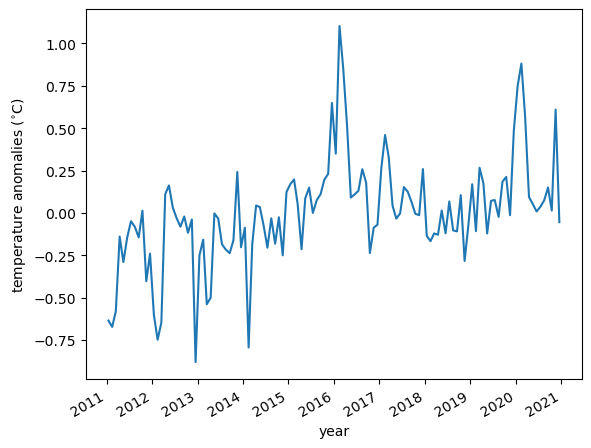

In [26]:
ds3_ano.plot()
plt.ylabel('temperature anomalies ($^{\circ}$C)')
plt.xlabel('year')

## 3.2

In [32]:
temp = ds3['tmp']
temp = temp.resample(time='1Y').mean()
trend = xr.zeros_like(temp[0])
for ii in range(0,trend.shape[0]):
    for jj in range(0,trend.shape[1]):
        series = temp[:,ii,jj]
        trend[ii,jj] = stats.linregress(np.arange(0,10),series)[0]

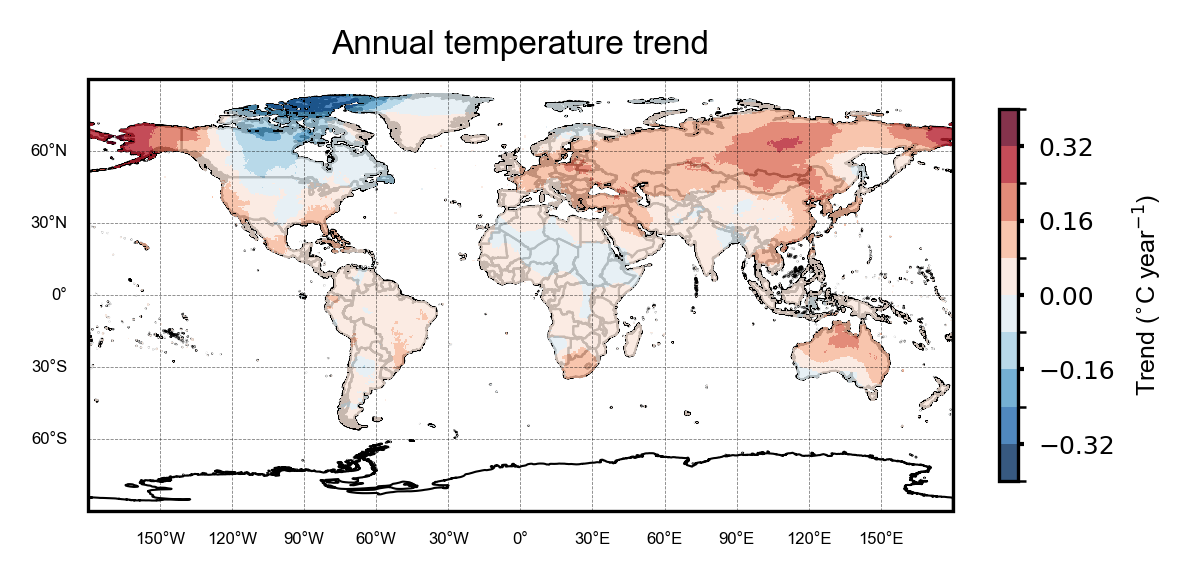

In [34]:
fig = plt.figure(figsize=(4,2),dpi=300)
ax1 = fig.add_subplot(111,projection = ccrs.PlateCarree())
ax1.add_feature(world, linewidth=0.5, zorder=1)
p1 = trend.plot(x='lon', y='lat', transform = ccrs.PlateCarree(),alpha=0.8, add_colorbar=False,levels=10)
gridline(ax1, low_cldarea_sw, 'lon', 'lat', 4, 0.2)
ax1.set_title('Annual temperature trend', fontdict={'size': 8,'family':'Arial'})
cb1 = plt.colorbar(p1,fraction=0.02)
cb1.ax.tick_params(labelsize=6, length=1.5,width=1)
cb1.set_label('Trend ($^{\circ}$C year$^{-1}$)', fontdict={'family':'Arial', 'size': 6})

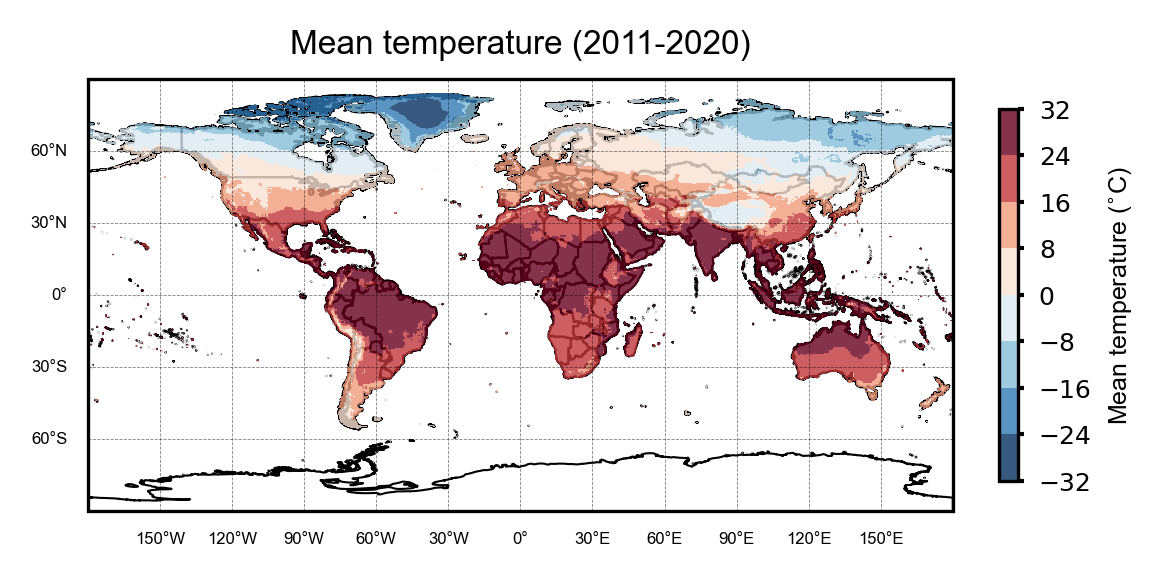

In [44]:
fig = plt.figure(figsize=(4,2),dpi=300)
ax1 = fig.add_subplot(111,projection = ccrs.PlateCarree())
ax1.add_feature(world, linewidth=0.5, zorder=1)
p1 = temp.mean('time').plot(x='lon', y='lat', transform = ccrs.PlateCarree(),alpha=0.8, add_colorbar=False,levels=10)
gridline(ax1, low_cldarea_sw, 'lon', 'lat', 4, 0.2)
ax1.set_title('Mean temperature (2011-2020)', fontdict={'size': 8,'family':'Arial'})
cb1 = plt.colorbar(p1,fraction=0.02)
cb1.ax.tick_params(labelsize=6, length=1.5,width=1)
cb1.set_label('Mean temperature ($^{\circ}$C)', fontdict={'family':'Arial', 'size': 6})

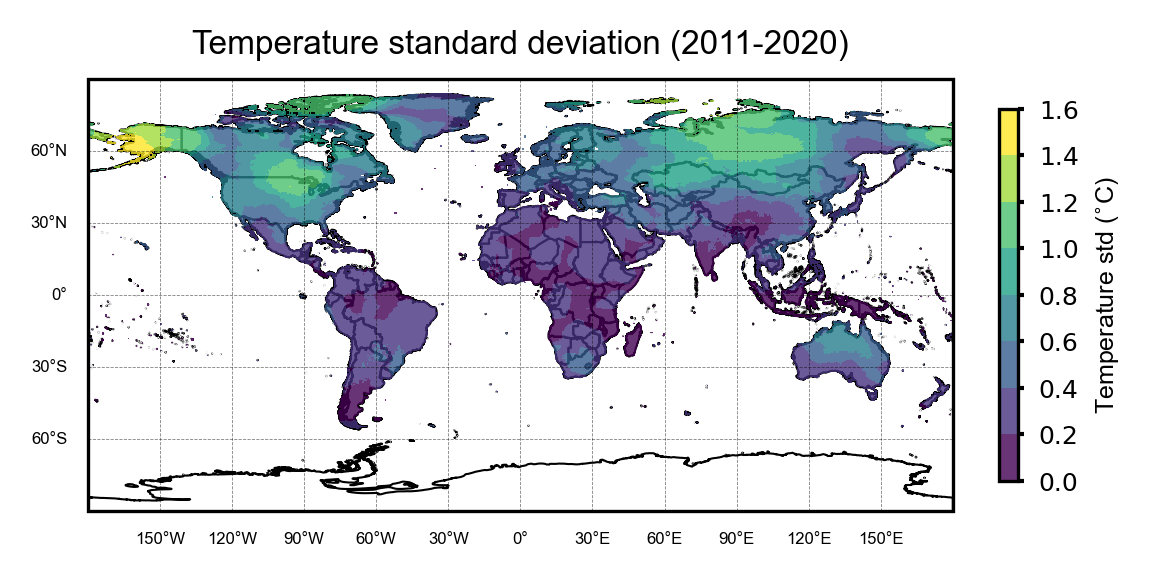

In [45]:
fig = plt.figure(figsize=(4,2),dpi=300)
ax1 = fig.add_subplot(111,projection = ccrs.PlateCarree())
ax1.add_feature(world, linewidth=0.5, zorder=1)
p1 = temp.std('time').plot(x='lon', y='lat', transform = ccrs.PlateCarree(),alpha=0.8, add_colorbar=False,levels=10)
gridline(ax1, low_cldarea_sw, 'lon', 'lat', 4, 0.2)
ax1.set_title('Temperature standard deviation (2011-2020)', fontdict={'size': 8,'family':'Arial'})
cb1 = plt.colorbar(p1,fraction=0.02)
cb1.ax.tick_params(labelsize=6, length=1.5,width=1)
cb1.set_label('Temperature std ($^{\circ}$C)', fontdict={'family':'Arial', 'size': 6})

([<matplotlib.axis.XTick at 0x1a327be9f00>,
 [Text(-75, 0, '-75$^{\\circ}$'),
  Text(-50, 0, '-50$^{\\circ}$'),
  Text(-25, 0, '-25$^{\\circ}$'),
  Text(0, 0, '0$^{\\circ}$'),
  Text(25, 0, '25$^{\\circ}$'),
  Text(50, 0, '50$^{\\circ}$'),
  Text(75, 0, '75$^{\\circ}$')])

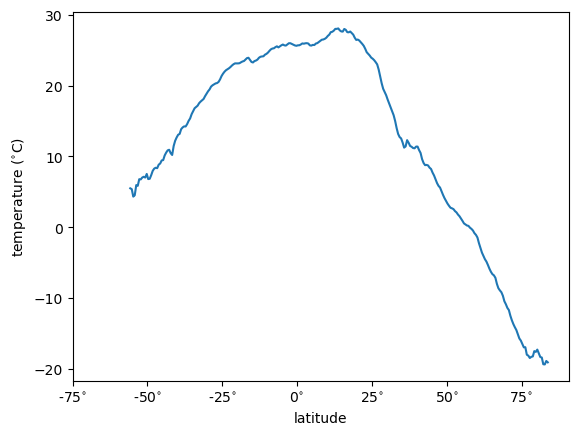

In [42]:
#latitude mean
lat_temp = temp.mean(('lon','time'))
lat_temp.plot()
plt.ylabel('temperature ($^{\circ}$C)')
plt.xlabel('latitude')
plt.xticks([-75,-50,-25,0,25,50,75],['-75$^{\circ}$','-50$^{\circ}$','-25$^{\circ}$','0$^{\circ}$','25$^{\circ}$','50$^{\circ}$','75$^{\circ}$'])

([<matplotlib.axis.XTick at 0x1a3295fe200>,
 [Text(-150, 0, '-150$^{\\circ}$'),
  Text(-100, 0, '-100$^{\\circ}$'),
  Text(-50, 0, '-50$^{\\circ}$'),
  Text(0, 0, '0$^{\\circ}$'),
  Text(50, 0, '50$^{\\circ}$'),
  Text(100, 0, '100$^{\\circ}$'),
  Text(150, 0, '150$^{\\circ}$')])

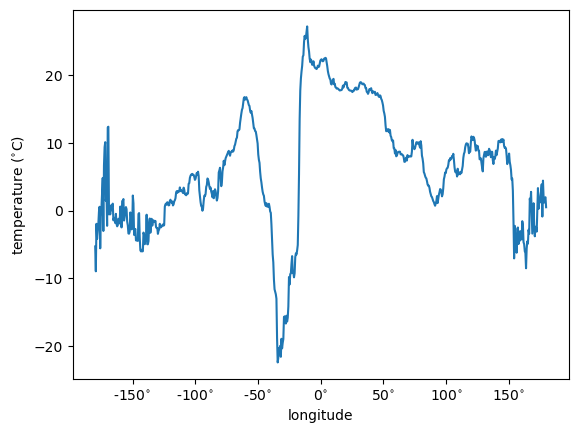

In [43]:
#longitude mean
lon_temp = temp.mean(('lat','time'))
lon_temp.plot()
plt.ylabel('temperature ($^{\circ}$C)')
plt.xlabel('longitude')
plt.xticks([-150,-100,-50,0,50,100,150],['-150$^{\circ}$','-100$^{\circ}$','-50$^{\circ}$','0$^{\circ}$','50$^{\circ}$','100$^{\circ}$','150$^{\circ}$'])